# YoloSAM: Medical Scar Detection & Segmentation Tutorial

Welcome to YoloSAM! This notebook will guide you through:
- Installation and setup
- Data preparation
- Training YOLO and SAM models
- Making predictions
- Evaluating results


In [ ]:
# Install YoloSAM
!git clone https://github.com/Danialmoa/YoloSAM
%cd YoloSAM
!pip install -e . 

# Data preparation
Data should be in the following format:

```
data/
├── train/
│   ├── images/
│   │   ├── image1.jpg
│   │   ├── image2.jpg
│   │   └── ...
│   ├── masks/
│   │   ├── image1.jpg
│   │   ├── image2.jpg
│   │   └── ...
├── val/
│   ├── images/
│   │   ├── image1.jpg
│   │   ├── image2.jpg
│   │   └── ...
│   ├── masks/
│   │   ├── image1.jpg
│   │   ├── image2.jpg
│   │   └── ...
```

In [1]:
# Finetune model
# Training YOLO model (YOLO11n)

# Convert masks to YOLO labels in the same folder structure.
from utils.mask_to_yolo import MaskToYOLOConverter
from utils.config import YOLOConfig
from scripts.train_yolo import YOLOTrainer


converter = MaskToYOLOConverter(class_id=0)  # 0 for 'scar' class

# Convert your dataset in place
converter.convert_dataset_inplace(
    base_path='../sample_data',
    min_area=5,  # Minimum area threshold (adjust as needed)
    splits=['train', 'val']
)

config = YOLOConfig(
    # Model settings
    model_type="yolo11n",
    device="cpu",
    pretrained_path="../checkpoints",
    
    # Dataset paths
    dataset_path="../sample_data/train",
    val_dataset_path="../sample_data/val",
    class_names=['scar'],
    
    # Training parameters
    epochs=10,
    batch_size=16,
    image_size=640,
    patience=50,
    
    # Augmentation (optimized for medical scars)
    mosaic=0.9,
    mixup=0.1,
    copy_paste=0.4,
    degrees=15.0,
    hsv_v=0.3,
    
    # Detection parameters
    iou_threshold=0.2,
    conf_threshold=0.15,
    max_detections=2,
    
    # Project settings
    project_name="yolo_scar_detection",
    experiment_name="enhanced_scar_detection",
    
    # Wandb settings
    wandb_project="YOLO-scar-detection",
    wandb_name="scar_detection_v1",
    wandb_mode="disabled"  # Set to "online" to enable wandb logging
)
    
# Create trainer
trainer = YOLOTrainer(config)

# Train the model
results = trainer.train()


Processing train split...
Found 6 mask files in train


Converting train: 100%|██████████| 6/6 [00:00<00:00, 402.09it/s]


Completed train split: 6 files processed
Labels saved to: ../sample_data/train/labels
Processing val split...
Found 6 mask files in val


Converting val: 100%|██████████| 6/6 [00:00<00:00, 728.68it/s]

Completed val split: 6 files processed
Labels saved to: ../sample_data/val/labels
Dataset conversion completed!
Your dataset structure is now:
  ../sample_data/train/
    images/
    masks/
    labels/  <- NEW
  ../sample_data/val/
    images/
    masks/
    labels/  <- NEW
Loading pretrained YOLO model: yolo11n



100%|██████████| 5.35M/5.35M [00:00<00:00, 19.1MB/s]


Created dataset configuration at: ../sample_data/dataset.yaml
Starting YOLO training for 10 epochs
Starting YOLO training with configuration:
  data: ../sample_data/dataset.yaml
  epochs: 10
  imgsz: 640
  batch: 16
  patience: 50
  box: 7.5
  cls: 0.5
  dfl: 1.5
  iou: 0.2
  max_det: 2
  mosaic: 0.9
  mixup: 0.1
  copy_paste: 0.4
  scale: 0.5
  fliplr: 0.5
  flipud: 0.1
  degrees: 15.0
  translate: 0.3
  hsv_h: 0.0
  hsv_s: 0.0
  hsv_v: 0.3
  lr0: 0.001
  lrf: 0.0001
  warmup_epochs: 10
  weight_decay: 0.001
  save_period: 50
  project: runs
  name: yolo_scar_detection
  multi_scale: True
  device: cpu
Ultralytics 8.3.159 🚀 Python-3.11.12 torch-2.6.0 CPU (Apple M1)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.4, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../sample_data/dataset.yaml, degrees=15.0, deterministic=True, devi

train: Scanning /Users/danialmoafi/Developer/YoloSAM/sample_data/train/labels.cache... 6 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6/6 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 125.6±87.4 MB/s, size: 36.4 KB)


val: Scanning /Users/danialmoafi/Developer/YoloSAM/sample_data/val/labels.cache... 6 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6/6 [00:00<?, ?it/s]


Plotting labels to runs/yolo_scar_detection/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.001), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/yolo_scar_detection
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10         0G      2.487      5.375      2.485          7        512: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.14s/it]

                   all          6          7          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10         0G      3.887      5.429      2.585          7        352: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

                   all          6          7          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10         0G      2.343      4.358      2.314          7        416: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]

                   all          6          7          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10         0G      2.313      6.756      2.274          7        864: 100%|██████████| 1/1 [00:04<00:00,  4.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

                   all          6          7          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10         0G      2.632      4.779      2.473          7        448: 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.82it/s]

                   all          6          7          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10         0G      2.188      7.842      1.955          7        928: 100%|██████████| 1/1 [00:05<00:00,  5.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

                   all          6          7          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10         0G      2.424      4.781      2.002          7        448: 100%|██████████| 1/1 [00:01<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]

                   all          6          7          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10         0G      2.098      5.617      2.145          7        672: 100%|██████████| 1/1 [00:02<00:00,  2.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

                   all          6          7          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10         0G      1.989      6.842      1.986          7        960: 100%|██████████| 1/1 [00:07<00:00,  7.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]

                   all          6          7          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10         0G      1.881      4.918      1.833          7        640: 100%|██████████| 1/1 [00:01<00:00,  1.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.91it/s]

                   all          6          7          0          0          0          0



10 epochs completed in 0.012 hours.
Optimizer stripped from runs/yolo_scar_detection/weights/last.pt, 5.5MB
Optimizer stripped from runs/yolo_scar_detection/weights/best.pt, 5.5MB

Validating runs/yolo_scar_detection/weights/best.pt...
Ultralytics 8.3.159 🚀 Python-3.11.12 torch-2.6.0 CPU (Apple M1)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


                   all          6          7          0          0          0          0
Speed: 0.8ms preprocess, 76.1ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/yolo_scar_detection
YOLO created output directory: runs/yolo_scar_detection/yolo_scar_detection
Wandb mode: disabled
Training completed!


## FineTune SAM model 
Two ways to finetune SAM model

1. Using Yolo prompt
2. Using ground truth mask


In [ ]:
# FineTune SAM model With Yolo prompt

from scripts.train_sam import TrainSAM
from utils.dataset import SAMDataset
from utils.config import SAMFinetuneConfig, SAMDatasetConfig

finetune_config = SAMFinetuneConfig(
        device='cpu',
        wandb_project='SAM_finetune',
        wandb_name='test_run',
        model_type='vit_b',
        sam_path='../checkpoints/sam_vit_b_01ec64.pth',
        num_epochs=1,
        batch_size=2,
        learning_rate=1e-5,
        weight_decay=1e-4,
        lambda_bce=0.2, 
        lambda_kl=0.2,
        sigma=1,
        wandb_mode='disabled',
        num_workers=0
    )

train_dataset_config = SAMDatasetConfig(
    dataset_path='../sample_data/train/',
    remove_nonscar=True,
    sample_size=2,
    point_prompt=False, # -> If True, Random generation of points base on the mask
    box_prompt=False, # -> If True, box prompt is generated based on the mask
    enable_direction_aug=False, # -> If True, direction augmentation is enabled
    enable_size_aug=False, # -> If True, size augmentation is enabled
    yolo_prompt=True, # -> If True, yolo prompt is generated based on the mask
    yolo_model_path='../checkpoints/yolo11n.pt', # -> Path to the yolo model
    yolo_conf_threshold=0.25, # -> Confidence threshold for yolo
    yolo_iou_threshold=0.45, # -> IoU threshold for yolo
    yolo_imgsz=640, # -> Image size for yolo
    image_size=1024, 
    train=True
)

val_dataset_config = SAMDatasetConfig(
    dataset_path='../sample_data/val/',
    remove_nonscar=True,
    sample_size=2,
    point_prompt=False,
    box_prompt=False,
    yolo_prompt=True,
    yolo_model_path='../checkpoints/yolo11n.pt',
    yolo_conf_threshold=0.25,
    yolo_iou_threshold=0.45,
    yolo_imgsz=640,
    image_size=1024,
    train=False
)

train_dataset = SAMDataset(train_dataset_config)
val_dataset = SAMDataset(val_dataset_config)

trainer = TrainSAM(finetune_config, train_dataset, val_dataset)
trainer.train(finetune_config.num_epochs)

In [ ]:
# FineTune SAM model with ground truth mask

from scripts.train_sam import TrainSAM
from utils.dataset import SAMDataset
from utils.config import SAMFinetuneConfig, SAMDatasetConfig

finetune_config = SAMFinetuneConfig(
        device='cpu',
        wandb_project='SAM_finetune',
        wandb_name='test_run',
        model_type='vit_b',
        sam_path='../checkpoints/sam_vit_b_01ec64.pth',
        num_epochs=1,
        batch_size=2,
        learning_rate=1e-5,
        weight_decay=1e-4,
        lambda_bce=0.2, 
        lambda_kl=0.2,
        sigma=1,
        wandb_mode='disabled',
        num_workers=0
    )

train_dataset_config = SAMDatasetConfig(
    dataset_path='../sample_data/train/',
    remove_nonscar=True, # -> If True, remove non-scar images
    sample_size=2,
    point_prompt=True, # -> If True, Random generation of points base on the mask
    point_prompt_types=['positive'], # -> Types of points to generate (Negative, Positive)
    num_points=3, # -> Number of points to generate
    box_prompt=True, # -> If True, box prompt is generated based on the mask
    enable_direction_aug=True, # -> If True, direction augmentation is enabled
    enable_size_aug=True, # -> If True, size augmentation is enabled
    yolo_prompt=False, # -> If True, yolo prompt is generated based on the mask
    image_size=1024, 
    train=True
)

val_dataset_config = SAMDatasetConfig(
    dataset_path='../sample_data/val/',
    remove_nonscar=True,
    sample_size=2,
    point_prompt=True,
    point_prompt_types=['positive'],
    num_points=3,
    box_prompt=True,
    enable_direction_aug=False,
    enable_size_aug=False,
    image_size=1024,
    train=False
)

train_dataset = SAMDataset(train_dataset_config)
val_dataset = SAMDataset(val_dataset_config)

trainer = TrainSAM(finetune_config, train_dataset, val_dataset)
trainer.train(finetune_config.num_epochs)

# Inference Model

Loading YOLO model from checkpoint: ../runs/yolo_scar_detection2/weights/best.pt
Load SAM model from  ../checkpoints/sam_vit_b_01ec64.pth
YoloSAM Inference pipeline initialized on cpu


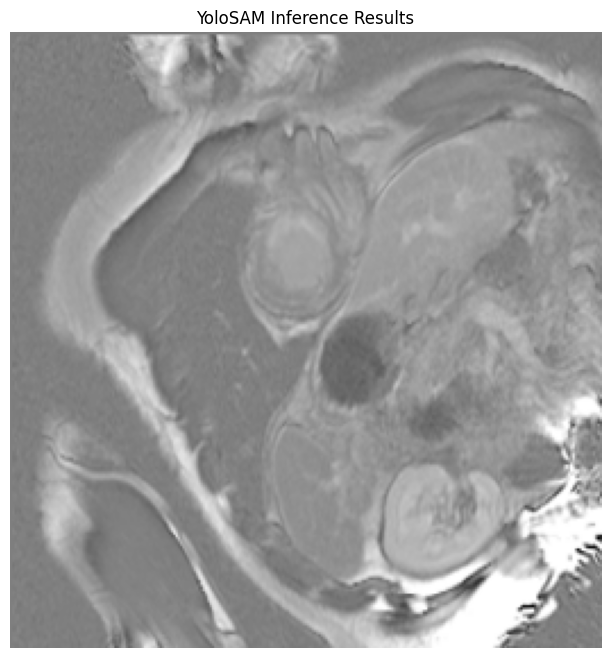

In [9]:
from scripts.inference import YoloSAMInference
from utils.config import YoloSAMInferenceConfig
import matplotlib.pyplot as plt

config = YoloSAMInferenceConfig(
    yolo_checkpoint_path="../runs/yolo_scar_detection2/weights/best.pt",
    sam_checkpoint_path="../checkpoints/sam_vit_b_01ec64.pth",
    device="cpu"
)

inference_pipeline = YoloSAMInference(config=config)

image_path = "../sample_data/val/images/Case_P004_slice_01.png"

results = inference_pipeline.predict(image_path)
output_image = inference_pipeline.visualize_results(results)

plt.figure(figsize=(12, 8))
plt.imshow(output_image)
plt.title("YoloSAM Inference Results")
plt.axis('off')
plt.show()